## Sensitivity analysis 
In this part of the sensitivity analysis, a Sobol analysis will be performed. The Sobol will find the variance each parameter has on the specified outcomes. 

### Sobol Analysis

In [2]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import ema_logging
from ema_workbench import Policy, MultiprocessingEvaluator, Samplers, SequentialEvaluator 
from SALib.analyze import sobol
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
%matplotlib inline
import numpy as np
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

from problem_formulation import get_model_for_problem_formulation

from dike_model_function import DikeNetwork

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(6)

In [4]:
policies = [Policy(f"DikeIncrease_{i}", **{f"{dike}_DikeIncrease {n}": i for dike in dike_model.function.dikelist for n in dike_model.function.planning_steps}, **{"EWS_DaysToThreat": 2}) for i in range(1, 11)]

In [5]:
#Running experiments 
with SequentialEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100, policies=policies, uncertainty_sampling=Samplers.SOBOL)

#Adding outcomes to experiments dataframe
for keys in outcomes.keys():
    experiments[keys] = outcomes[keys]
        
#Saving sobol outcomes to csv file
experiments.to_csv("output/outcomes_sobol_3.csv")

C:\Users\anna\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 400 scenarios * 10 policies * 1 model(s) = 4000 experiments
100%|██████████████████████████████████████| 4000/4000 [53:33<00:00,  1.24it/s]
[MainProcess/INFO] experiments finished


In [6]:
experiments = pd.read_csv('output/outcomes_sobol_3.csv')
#experiments.keys()

In [7]:
problem = get_SALib_problem(dike_model.uncertainties)
#print(problem)

In [8]:
#define outcomes of interest
ooi = ['Expected Annual Damage', 'Dike Investment Costs']

uncertainties = [
    'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
    'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
    'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
    'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
    'discount rate 2'
]

                                   ST       ST_conf
A.0_ID flood wave shape  7.125897e-04  1.165798e-03
A.1_Bmax                 6.377328e-04  1.136887e-03
A.1_Brate                5.433502e-07  8.010193e-07
A.1_pfail                6.595532e-01  2.589252e-01
A.2_Bmax                 8.957508e-06  1.797141e-05
A.2_Brate                5.950304e-06  1.085871e-05
A.2_pfail                9.494552e-03  2.832362e-02
A.3_Bmax                 5.146216e-05  1.501677e-04
A.3_Brate                1.225857e-05  3.645701e-05
A.3_pfail                6.404849e-02  1.118946e-01
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                3.550917e-04  8.630616e-04
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                2.006157e-02  4.097124e-02
discount rate 0          1.834468e-02  3.422248e-02
discount rate 1          6.177321e-03  6.182319e-03
discount rat

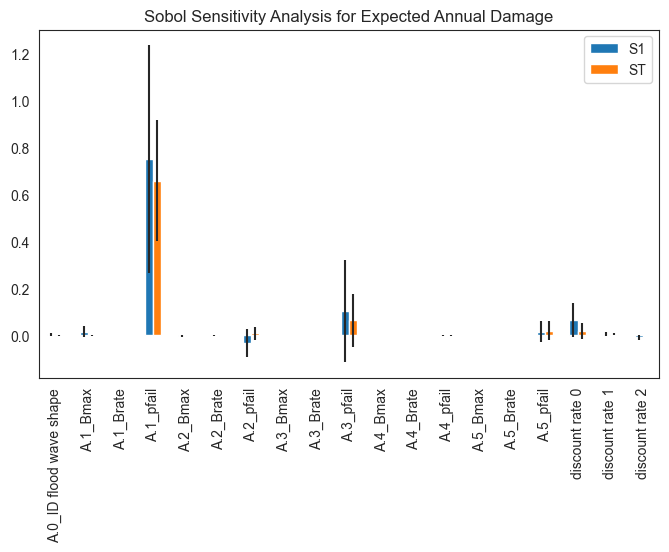

                          ST  ST_conf
A.0_ID flood wave shape  0.0      0.0
A.1_Bmax                 0.0      0.0
A.1_Brate                0.0      0.0
A.1_pfail                0.0      0.0
A.2_Bmax                 0.0      0.0
A.2_Brate                0.0      0.0
A.2_pfail                0.0      0.0
A.3_Bmax                 0.0      0.0
A.3_Brate                0.0      0.0
A.3_pfail                0.0      0.0
A.4_Bmax                 0.0      0.0
A.4_Brate                0.0      0.0
A.4_pfail                0.0      0.0
A.5_Bmax                 0.0      0.0
A.5_Brate                0.0      0.0
A.5_pfail                0.0      0.0
discount rate 0          0.0      0.0
discount rate 1          0.0      0.0
discount rate 2          0.0      0.0
                          S1  S1_conf
A.0_ID flood wave shape  0.0      0.0
A.1_Bmax                 0.0      0.0
A.1_Brate                0.0      0.0
A.1_pfail                0.0      0.0
A.2_Bmax                 0.0      0.0
A.2_Brate   

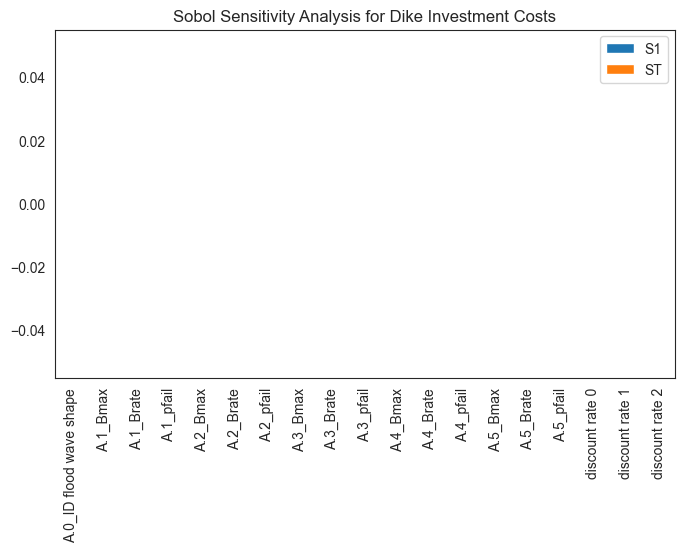

In [9]:
#analysing and plotting the sobol analysis for all outcomes of interest
problem = {
    'num_vars': len(uncertainties),
    'names': uncertainties,
    'bounds': [[0, 1]] * len(uncertainties)  # Assuming all uncertainties are normalized between 0 and 1
}

for outcome in ooi:
    #print(f"Performing Sobol analysis for {outcome}")
    Si = sobol.analyze(problem, experiments[outcome].to_numpy(), calc_second_order=True, print_to_console=True)

    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]
    #print(indices)

    indices.plot.bar(yerr=err.values.T, ax=ax)
    ax.set_title(f'Sobol Sensitivity Analysis for {outcome}')
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()
    #fig.savefig(f'img/Sobol for {outcome}')

In [10]:
outcomes = pd.read_csv('output/outcomes_sobol_3.csv')

dike_final_sobol = outcomes["Expected Annual Damage"]
dike_mean_sobol = np.mean(outcomes["Expected Annual Damage"])
dike_std_sobol = np.std(outcomes["Expected Annual Damage"])

### Extra Trees Analysis
The performing of the feature score analysis using the methods of extra trees. 

In [11]:
scores = feature_scoring.get_ex_feature_scores(experiments, dike_final_sobol, 
                                    max_features=0.6, mode=RuleInductionType.REGRESSION)[0]                                         
#scores

ValueError: Found input variables with inconsistent numbers of samples: [4000, 40000]

In [ ]:
X = experiments[uncertainties]
combined_scores = []

# Perform feature scoring in batches
for j in range(100, experiments.shape[0], 100):
    scores = feature_scoring.get_ex_feature_scores(
        X.iloc[0:j, :], 
        experiments[ooi[0]].iloc[0:j],
        max_features=0.6,
        mode=RuleInductionType.REGRESSION
    )[0]
    scores.columns = [j]
    combined_scores.append(scores)

# Combine scores
combined_scores_df = pd.concat(combined_scores, axis=1)
#print(combined_scores_df)

# Plotting the feature importances
combined_scores_mean = combined_scores_df.mean(axis=1)
combined_scores_std = combined_scores_df.std(axis=1)

sns.set_style('white')
fig, ax = plt.subplots()
combined_scores_mean.plot.bar(yerr=combined_scores_std, ax=ax)
ax.set_title("Feature importances using Extra Trees")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
#fig.savefig('img/ExtraTrees_FeatureImportance.png')

In [ ]:
fig, ax = plt.subplots(1)

combined_scores_df.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()
#fig.savefig('img/feature_scores.png')

In [ ]:
#creating a heatmap of the featuring scores 
sns.set(rc = {'figure.figsize':(10,10)})
svm=sns.heatmap(scores, cmap="viridis", annot=True)
plt.show()
figure = svm.get_figure()    
#figure.savefig('img/heatmap.png', dpi=400, bbox_inches='tight')